# Deep Drilling Field observing strategy

In [1]:
# Import required python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
from astropy.coordinates import SkyCoord
import astropy.units as u
import rubin_scheduler.scheduler.utils as sched_utils
from rubin_scheduler.utils import ddf_locations, ddf_locations_skycoord
from rubin_sim.data import get_baseline
import rubin_sim.maf as maf

In [2]:
# v3.4 runs
summaries = maf.get_metric_summaries(summary_source='summary_v3.4.h5')
print(f"This summary h5 file contains information on {len(summaries.index)} simulations.")
baselinerun = 'baseline_v3.4_10yrs'
ddf_accor = [r for r in summaries.index if r.startswith('ddf_acor')]
ddf_loaded = [r for r in summaries.index if r.startswith('ddf_loaded') and 'half' not in r]
# hack a rearrangement for ddf_loaded
ddf_loaded = ddf_loaded[1:] + ddf_loaded[0:1]
ddf_half = [r for r in summaries.index if r.startswith('ddf') and 'half' in r]
# hack a rearrangement for ddf_half
tmp = ddf_half[0:1] + ddf_half[2:] + ddf_half[1:2]
ddf_half = tmp
all_runs = [baselinerun] + ddf_accor + ddf_loaded + ddf_half
ddf_sets = [ddf_accor, ddf_loaded, ddf_half]
print(f"There are {len(ddf_accor) + len(ddf_loaded) + len(ddf_half)} specific DDF experiments.")

This summary h5 file contains information on 265 simulations.
There are 48 specific DDF experiments.


In [3]:
# v3.5 runs
summaries = maf.get_metric_summaries(summary_source='summary_v3.5.h5')
print(f"This summary h5 file contains information on {len(summaries.index)} simulations.")
baselinerun = 'baseline_v3.4_10yrs'
ddf_accor = [r for r in summaries.index if 'acord' in r ]
ddf_roll = [r for r in summaries.index if 'roll' in r and 'ddf' in r]
ddf_agn = [r for r in summaries.index if 'agn' in r and 'ddf' in r]
all_runs = [baselinerun] + ddf_agn + ddf_accor + ddf_roll
ddf_sets = [ddf_agn, ddf_accor, ddf_roll]
print(f"There are {len(all_runs) - 1} specific DDF experiments.")

This summary h5 file contains information on 14 simulations.
There are 4 specific DDF experiments.


In [4]:
metric_subsets = maf.get_metric_subsets()
msets = list(metric_subsets.groupby('metric subset').first().index)
# DDF specific metrics
[m for m in msets if 'DDF' in m]

['AGN SF DDF',
 'AGN TimeLag 100 days DDF',
 'AGN TimeLag 5 days DDF',
 'DDF Cadence',
 'DDF Depths',
 'SNIa DDF',
 'SNSL DDF']

### Deep drilling field observing strategy

A new series of DDF survey strategies is being explored in the v3.5 simulations. The opsim databases can be downloaded from:
https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.5/ <br>
and their corresponding configuration scripts can be found at https://github.com/lsst-sims/sims_featureScheduler_runs3.5

The detailed MAF metrics for each simulation are available here - http://astro-lsst-01.astro.washington.edu:8080 - with particular emphasis on the "DD metrics". (see for example the [baseline DD metrics](http://astro-lsst-01.astro.washington.edu:8080/allMetricResults?runId=2)). 


The baseline survey strategy for the DDFs includes 5 DDF pointings, with varying number of visits per DDF:
* COSMOS attains 10 year DDF depth by year 3, and continues observations thus acquiring almost double the other pointings.
* Euclid Deep Field South (EDFS) is split into two different pointings (a, b) to match the Euclid field size, but share the total number of visits.
* A rough baseline number is that each DDF obtains about 21,000 visits over 10 years, corresponding to about 6% of the total (2.1M) visits.

NOTE that v3.5 updates the DDF locations slightly, to the values specified in the 2018 cadence white papers. 

In [5]:
# Basic DDF information, number of visits from baseline simulation
ddfs = ddf_locations_skycoord()
conn = sqlite3.connect('ddf_roll_v3.5_10yrs.db')

nvis = {}
for i in ddfs:
    query = f'select count(*) from observations where scheduler_note like "%{i}%"'
    nvis[i] = int(pd.read_sql(query, conn).values[0][0])

In [6]:
pdfs = {}
for i in ddfs:
    ra = ddfs[i].ra.deg
    dec = ddfs[i].dec.deg
    coord = ddfs[i]
    ra_hours = coord.ra.hms
    eclip_lat = coord.barycentrictrueecliptic.lat.deg
    eclip_lon = coord.barycentrictrueecliptic.lon.deg
    gal_lon = coord.galactic.l.deg
    gal_lat = coord.galactic.b.deg
    nvis_ddf = nvis[i]
    pdfs[i] = [ra, dec, gal_lon, gal_lat, eclip_lon, eclip_lat, nvis_ddf]
d = pd.DataFrame(pdfs, index=['RA', 'Dec', 'Gal l', 'Gal b', 'Eclip l', 'Eclip b', 'Nvisits']).round(2)
d

,ELAISS1,XMM_LSS,ECDFS,COSMOS,EDFS_a,EDFS_b
RA,9.45,35.57,52.98,150.11,58.90,63.60
Dec,-44.02,-4.82,-28.12,2.23,-49.32,-47.60
Gal l,311.29,171.10,224.07,236.78,257.90,254.48
Gal b,-72.88,-58.91,-54.60,42.13,-48.46,-45.77
Eclip l,346.66,31.59,40.81,151.39,32.00,40.97
Eclip b,-43.20,-17.92,-45.44,-9.34,-66.61,-66.60
Nvisits,22579.00,22473.00,23611.00,44658.00,11575.00,11536.00


In [7]:
all_runs

['baseline_v3.4_10yrs',
 'ddf_agn_v3.5_10yrs',
 'acord_v3.5_10yrs',
 'ddf_roll_deep_v3.5_10yrs',
 'ddf_roll_v3.5_10yrs']

In the baseline simulation, visits are acquired in sequences where a DDF is observed continuously in grizy or ugriz filters for approximately one hour. Complete sequences consist of 
* 8 u band visits (if u is available)
* 10 g band visits
* 20 r band visits
* 20 i band visits
* 24 z band visits
* 18 y band visits (if y is available)
Each visit is 30 seconds of on-sky exposure time; u band visits are 1x30s while other bandpasses are 2x15s.

In the `acord` simulations, the sequences are as above, but the overall season length and pacing within the season is varied. There is a "high" and "low" portion of each season, where the rate of acquiring sequences increases or decreases.

In the `ddf_agn` simulations, sequences are split apart, using `ugr` and then `izy` in separate sequences.

In the `ddf_roll` simulation, two of the DDFs are chosen to 'roll', with 1/2 length sequences in the "off" years and more frequent sequences in the "on" years.
In the `ddf_roll_deep` simulation, two of the DDFs are chosen to "roll", with 1/2 length sequences in the "off" years and 1.5 length sequences in the "on" years.

In [8]:
#opsdb = 'ddf_agn_v3.5_10yrs.db'
opsdb = 'acord_ddf_v3.5_10yrs.db'
conn = sqlite3.connect(opsdb)
visits = pd.read_sql('select * from observations', conn)
ddf = visits.query('scheduler_note.str.contains("DD")')
print(len(ddf), len(visits), len(ddf)/len(visits))

ee = ddf.query('scheduler_note.str.contains("DD:ECDFS")')
#ee.groupby(['night'])['filter'].agg(['unique'])['unique']
ee.groupby(['night'])[['filter',]].nunique().describe()

128928 2130572 0.0605133269375548


,filter
count,505.000000
mean,2.607921
std,0.900141
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,5.000000


# Fraction of DDF time

Varying the DDF strategy can inadvertently change the overall number of DDF visits or the overall fraction of survey time devoted to DDF observations. Changes here can affect the overall metrics for the strategy, so is worth checking first to identify which runs could be considered the most "apples to apples". 

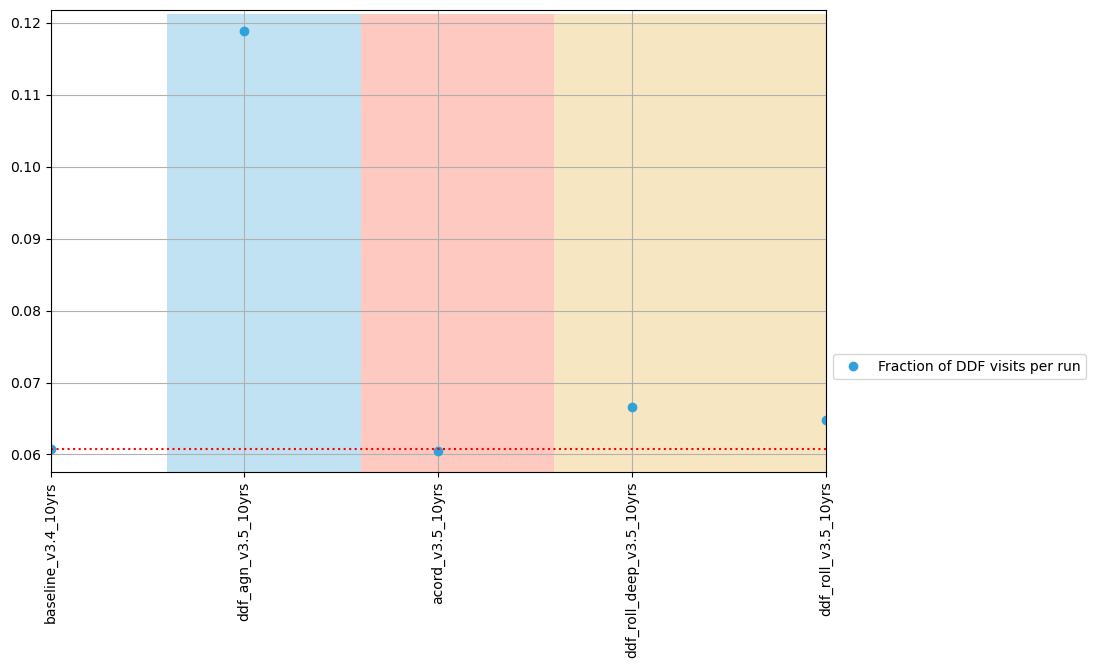

In [9]:
visits = ['Identity Nvisits All visits UniSlicer', 'Identity Nvisits DDF UniSlicer']
fraction = pd.DataFrame(summaries.loc[all_runs, visits[1]] / summaries.loc[all_runs, visits[0]],
                       columns=["Fraction of DDF visits per run"])

fig, ax = maf.plot_run_metric(fraction, shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ax.axhline(fraction.loc[baselinerun].values, color='red', linestyle=':')
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

The plot of fraction of DDF visits in each simulation shows that most of the simulations vary slightly around the 6% achieved in the baseline simulation .. the agn simulation will need to be repeated with adjustments. 

We can also double check on the end of survey coadded depths for each DDF in each filter -- in general, we'd expect them to track with the trends above: 

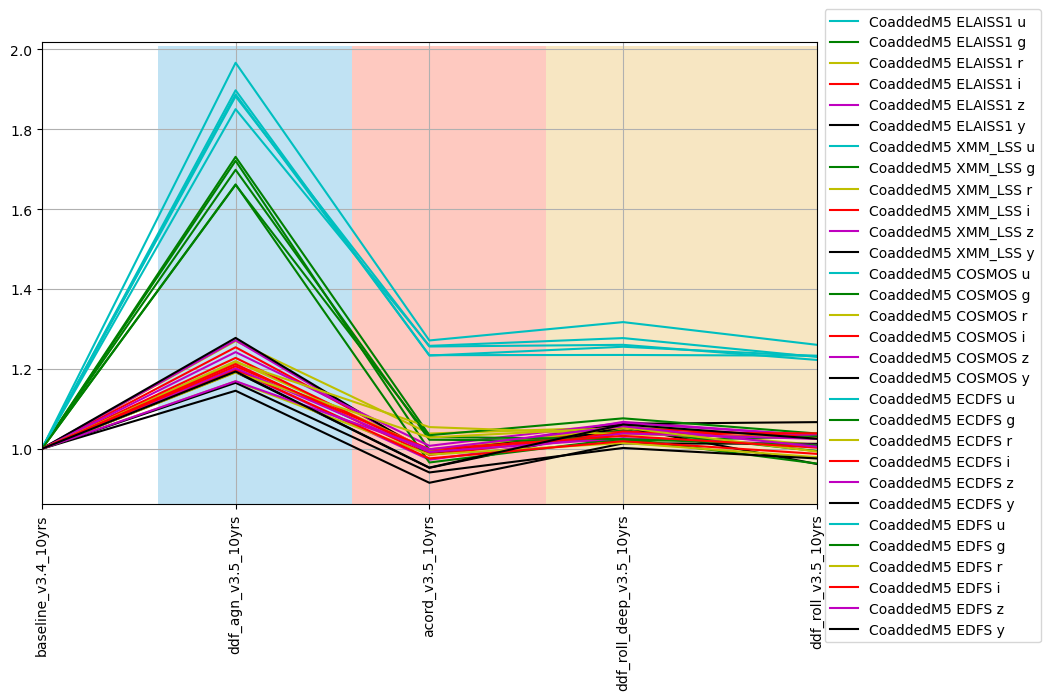

In [10]:
msub = metric_subsets.loc['DDF Depths'].query("not metric.str.contains('WFD') and metric.str.contains('Coadd')")
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, -0.3))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

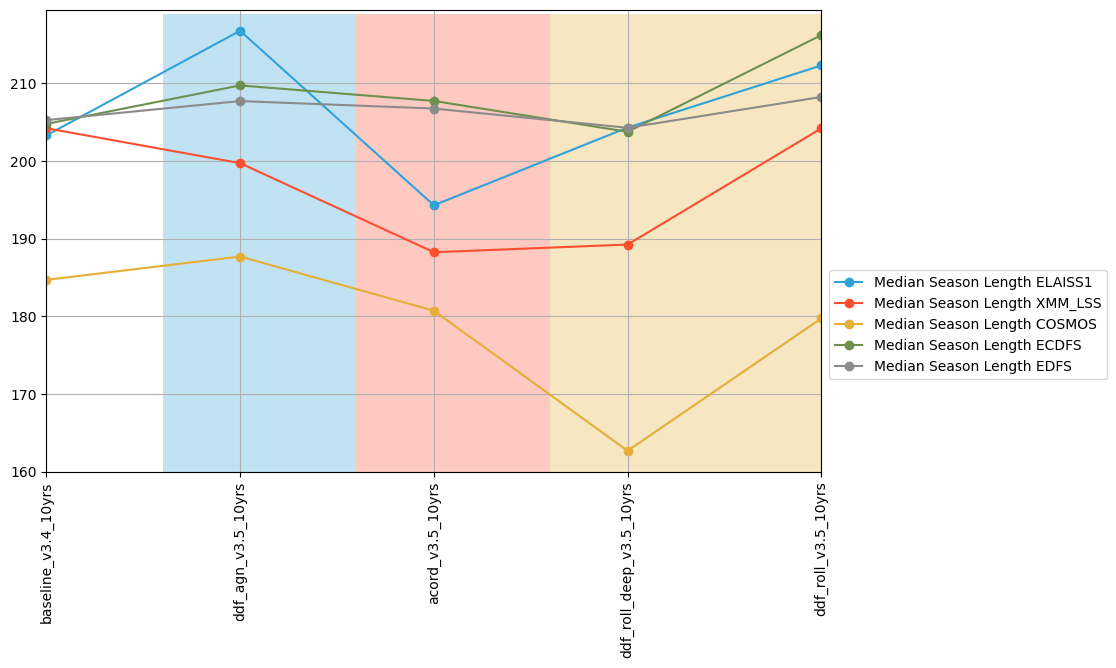

In [11]:
# Median season length (across all seasons)
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Season Length") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

Looking at the plot of median season length per DDF (median over all seasons) we see that the baseline simulation has typical season lengths of about 200/210 days, which is roughly consistent with the season lengths for the "loaded" families. The accordian family shows clear variation in season length, as was intended; a "sf" value of 10 results in longer seasons, while larger values start to reduce the season length, becoming noticable at around sf=20. 

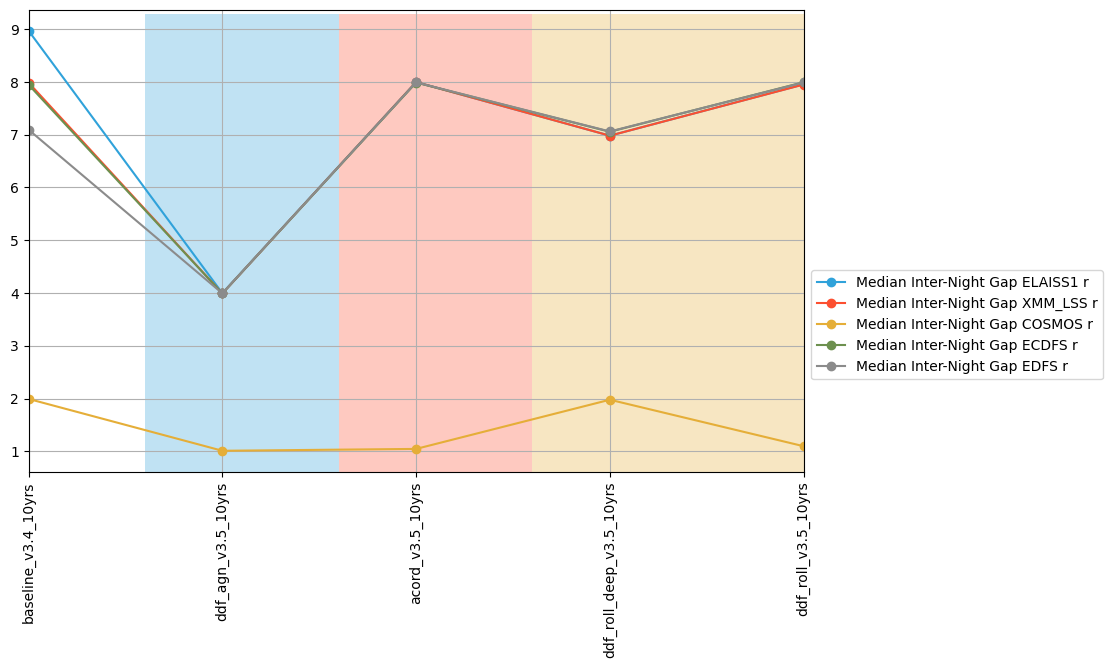

In [12]:
# Median inter-night gap in r band; i and z band similar trends
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Gap r") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

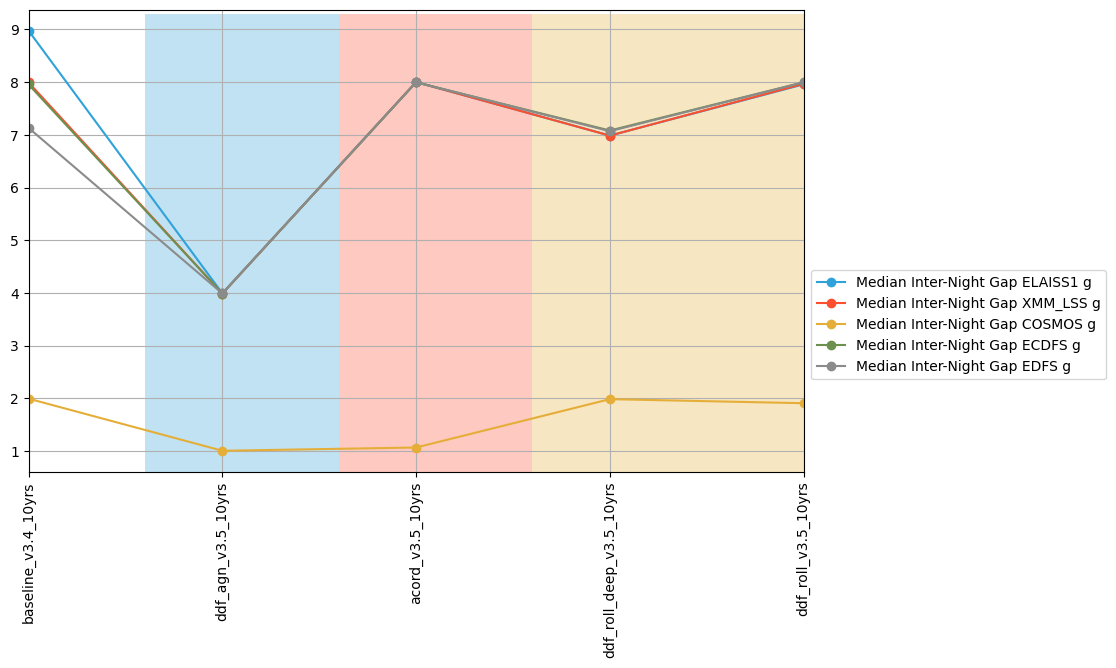

In [13]:
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Gap g") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

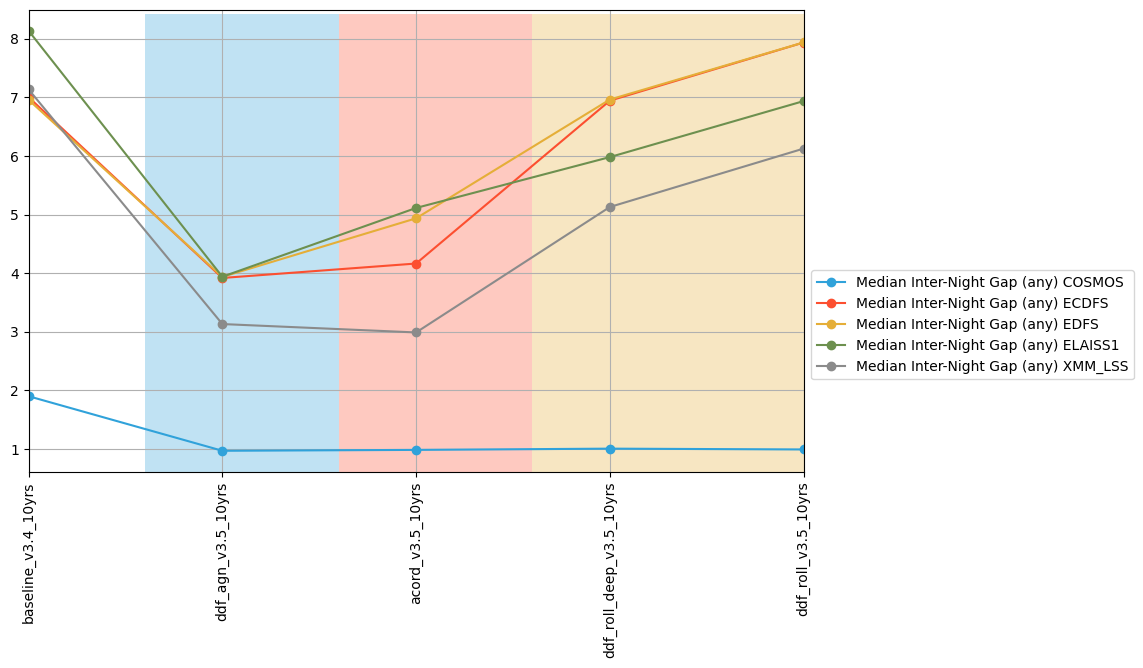

In [14]:
metric = [m for m in summaries if 'DD:' in m and 'Median Inter-Night Gap all bands' in m and 'WFD' not in m]
short_names = [f"Median Inter-Night Gap (any) {m.split('DD:')[1].split(' ')[0]}" for m in metric]
mapper = dict(zip(metric, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metric],
                              #metric_subset=msub,
                              metric_label_map=mapper,
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

The season length and number of visits are the primary levers on the median inter-night gap, although variations in the accordian families can also vary the gap -- especially when there is a very low low-season-rate ("lsr") with a large low-season-fraction ("lsf"), which concentrates visits into a highly active period in the center of the season. 

The COSMOS field tends to have very good inter-night gap values, because of the first three years with a large number of visits. 
The `ddf_loaded` simulations have inter-night gaps in any given filter similar to the baseline, despite splitting the sequences; when considering visits in any filter, the gaps are shorter than the baseline. The `ddf_loaded_half` series shows the effect of splitting the sequences in half as well, which results in them being scheduled more often -- reducing the inter-night gap. Because there are fewer g band visits in the WFD and they occur in a more limited span of time (around new moon), it seems the effect of only scheduling DDF visits when g band is already in use disrupts the g band DDF scheduling more than some other bands such as r band (u band would have already had this disruption in the baseline, as the filter is entirely removed from the telescope). 

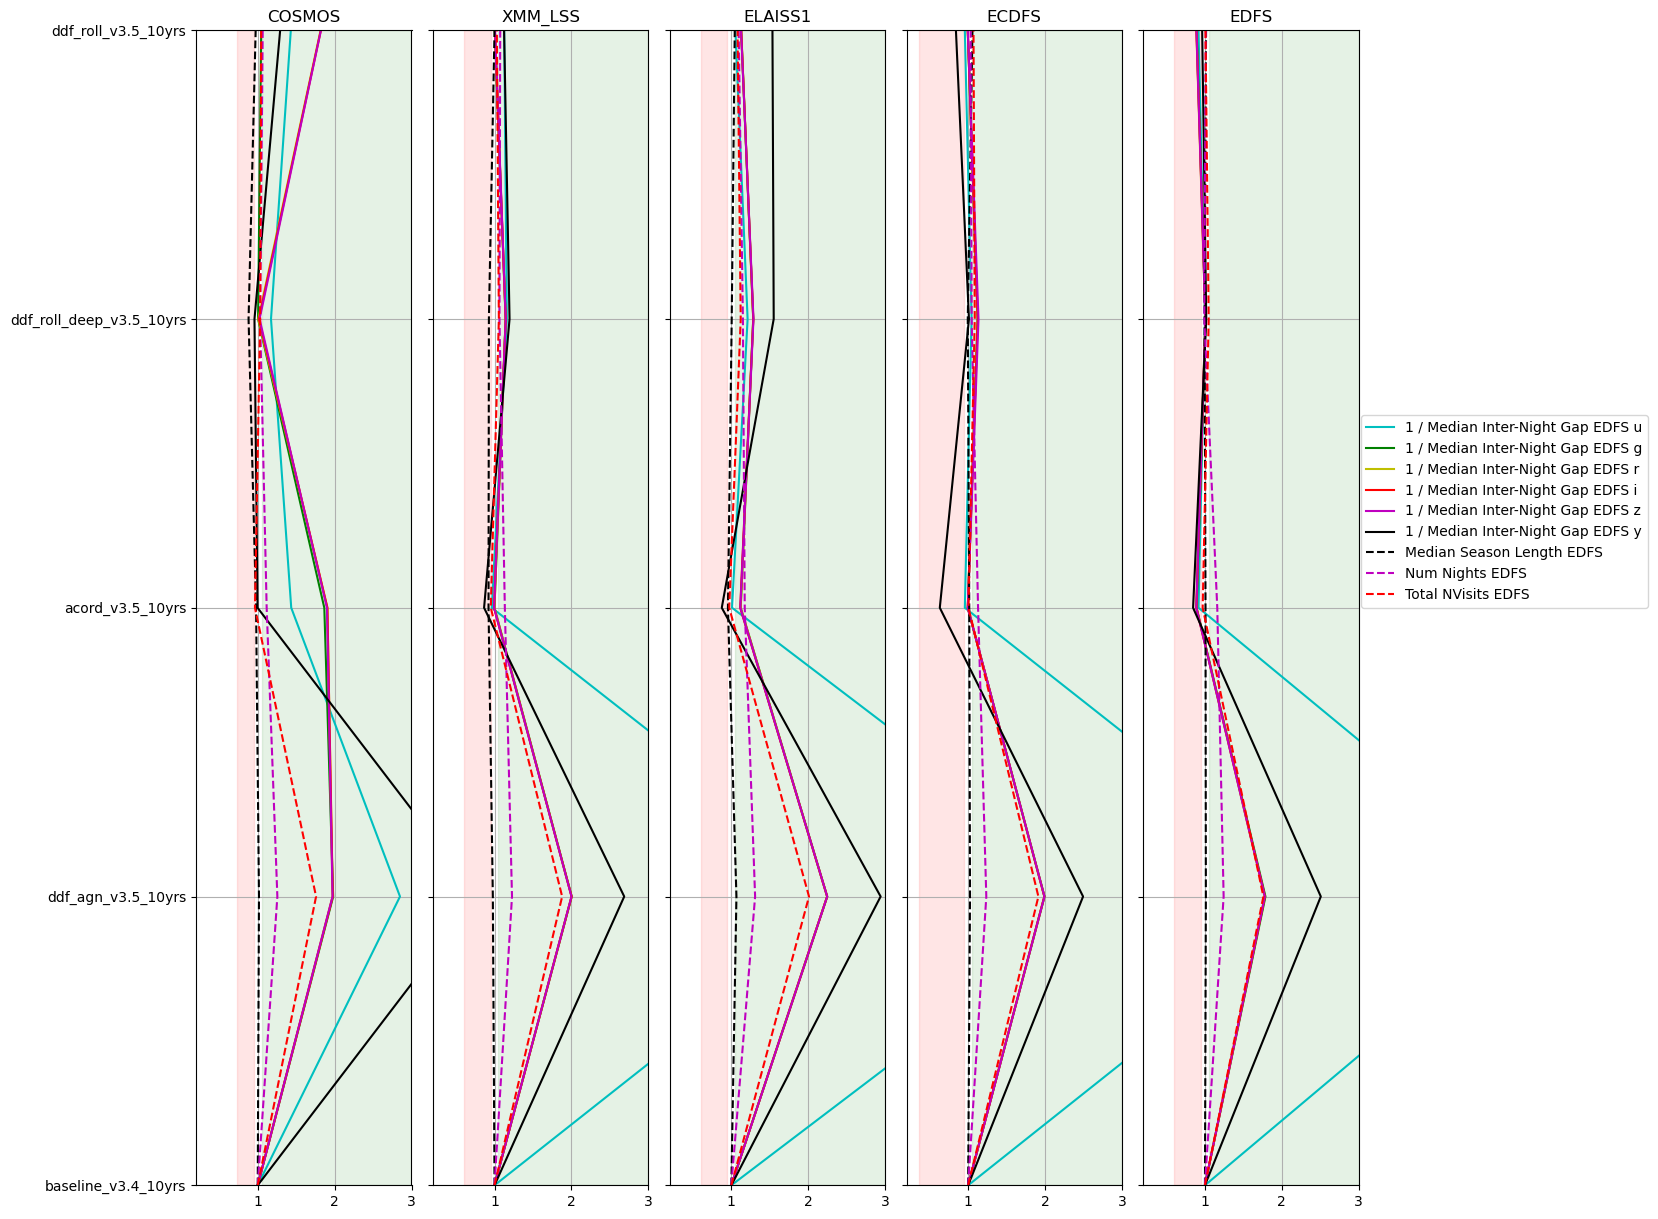

In [15]:
# Viewing this in a different way 
msub = metric_subsets.loc['DDF Cadence']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.2, 3)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

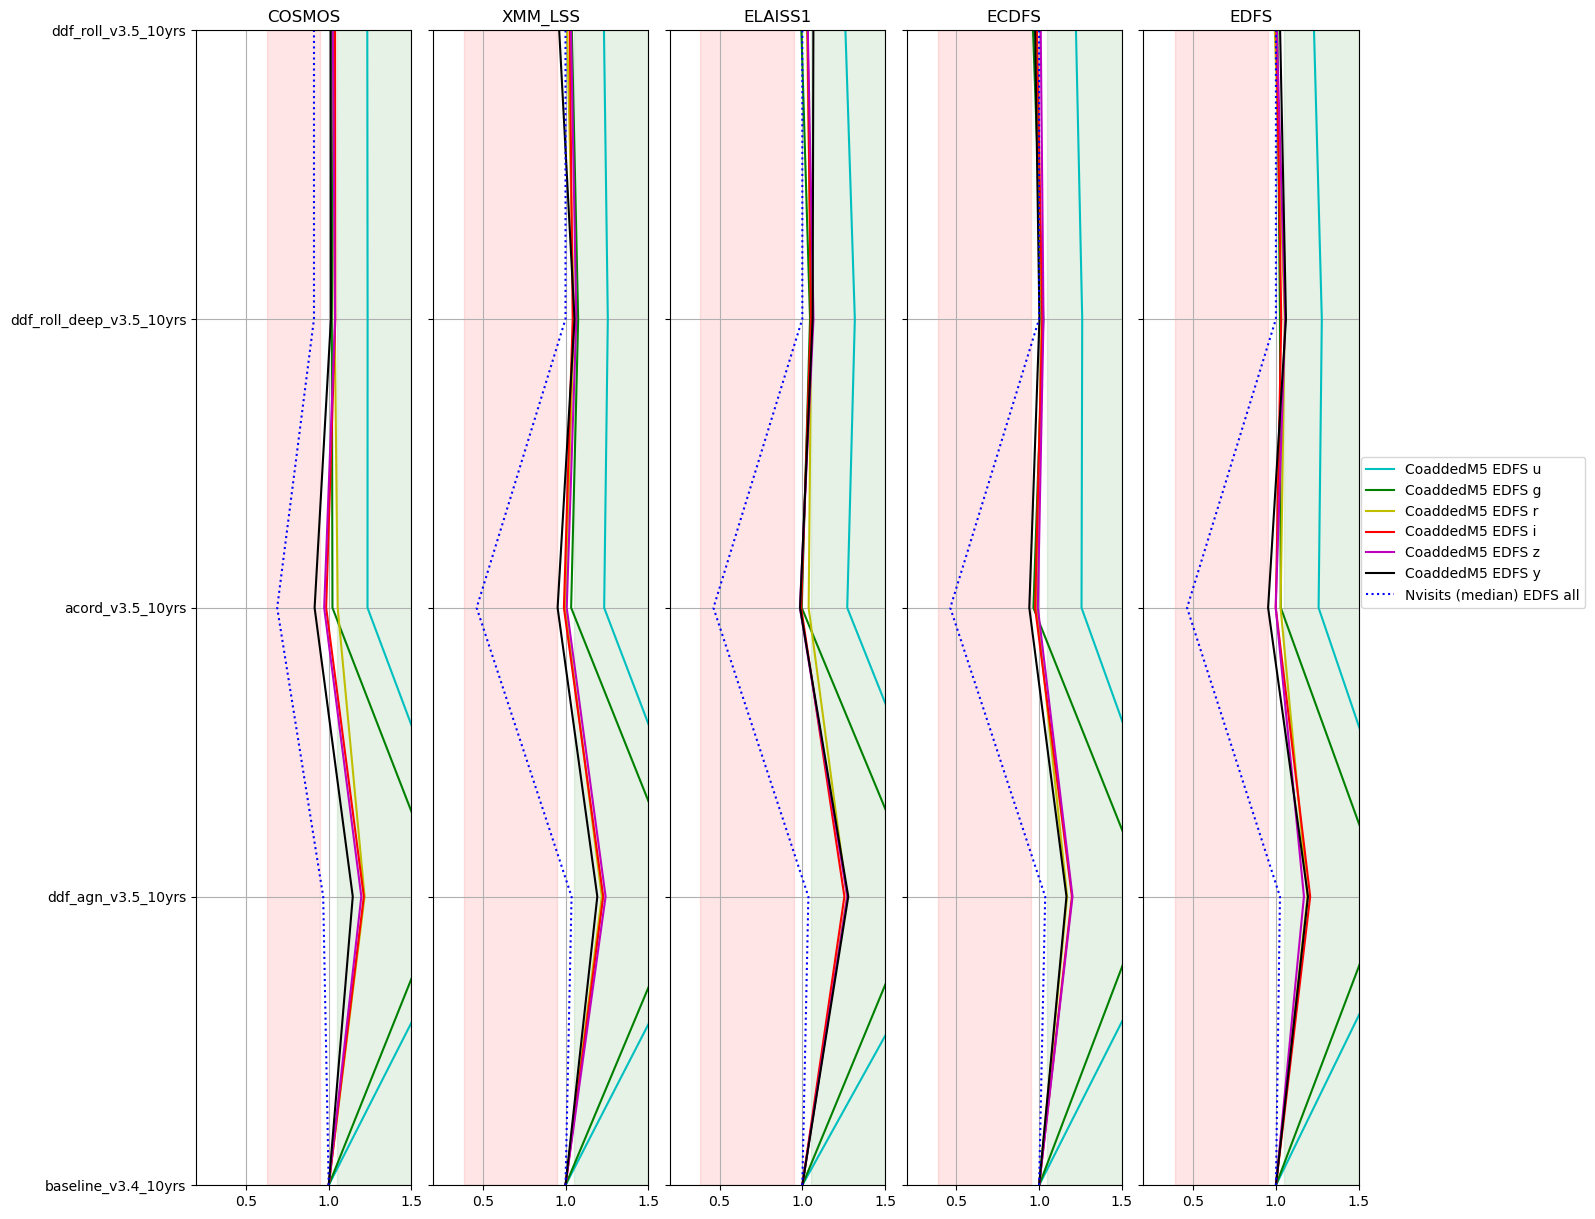

In [16]:
msub = metric_subsets.loc['DDF Depths']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.2, 1.5)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

With some insights into what's happening in the DDFs with these variations in survey strategy, let's look at the metrics more oriented toward science and see how they respond.

## AGN metrics 

Text(0.5, 1.0, 'AGN SF Error combined (2*u+g+r)')

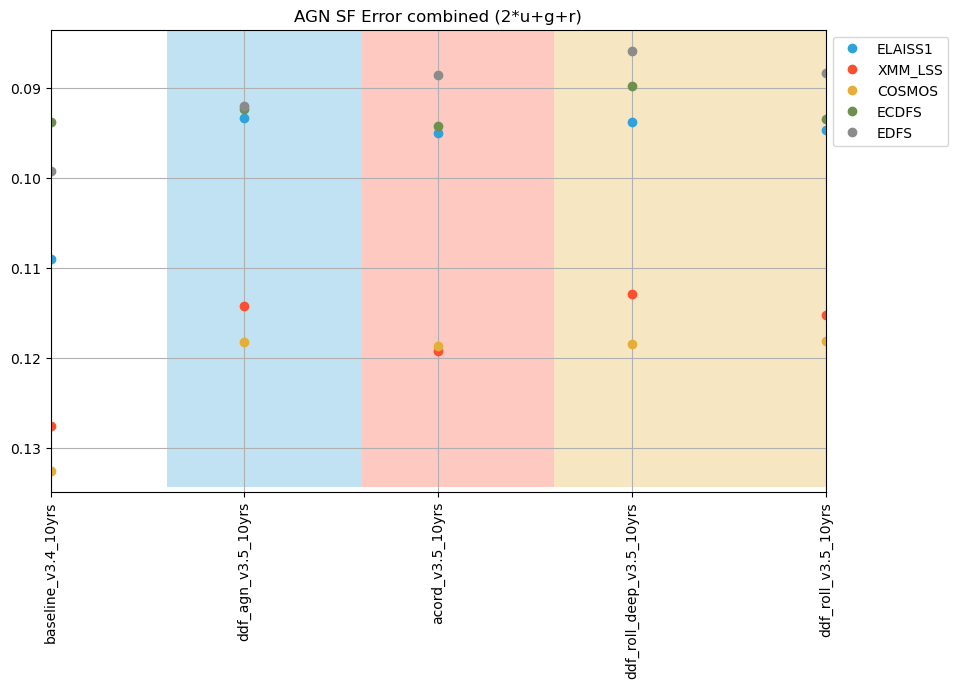

In [17]:
msub = metric_subsets.loc['AGN SF DDF'].query('not metric.str.contains("WFD")')
u = msub.iloc[::6]
g = msub.iloc[1::6]
r = msub.iloc[2::6]
ddf_names = [i.split("DD:")[1].split(' ')[0] for i in r['metric']]
agn_sf = pd.DataFrame(summaries.loc[all_runs, u['metric']].values * 2 
                      + summaries.loc[all_runs, g['metric']].values * 1 
                      + summaries.loc[all_runs, r['metric']].values * 1,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(agn_sf, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii
ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN SF Error combined (2*u+g+r)")

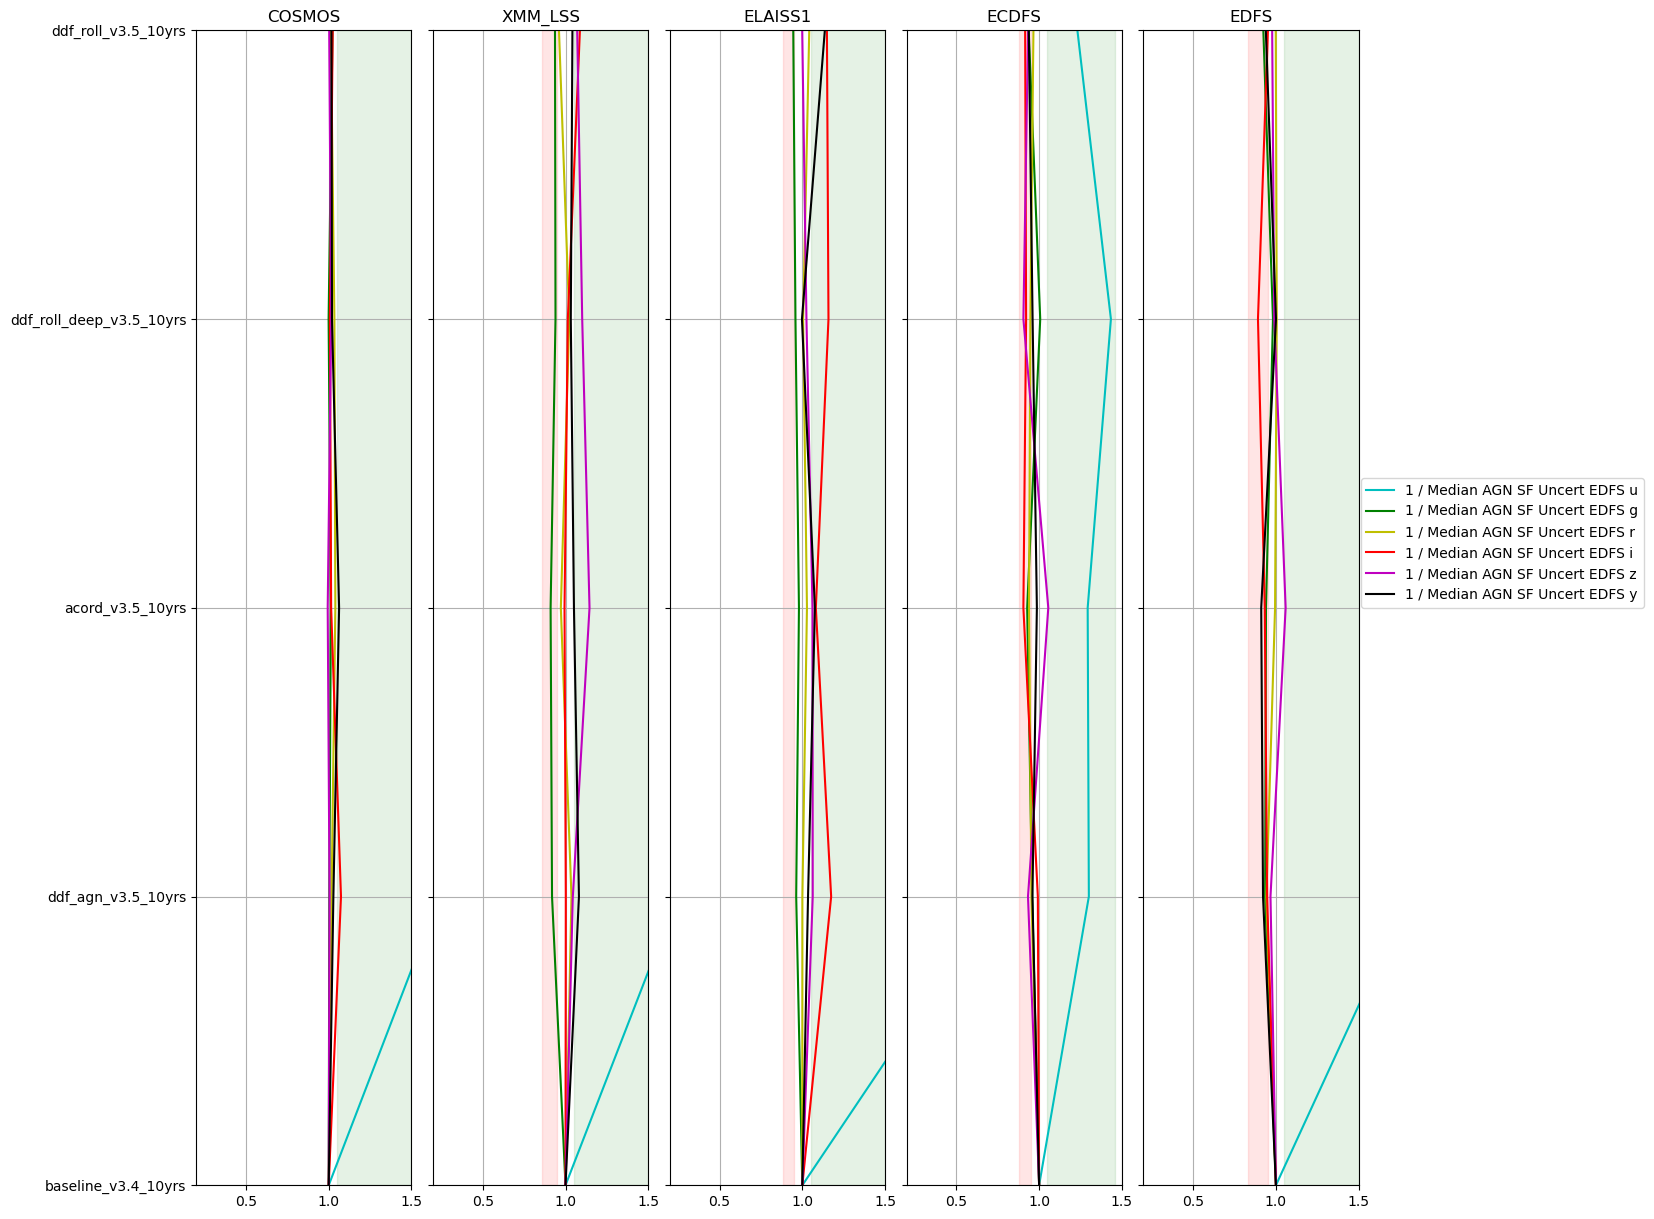

In [18]:
msub = metric_subsets.loc['AGN SF DDF']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.2, 1.5)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

Text(0.5, 1.0, 'AGN Timelags 100 days combined (2*u+g+r)')

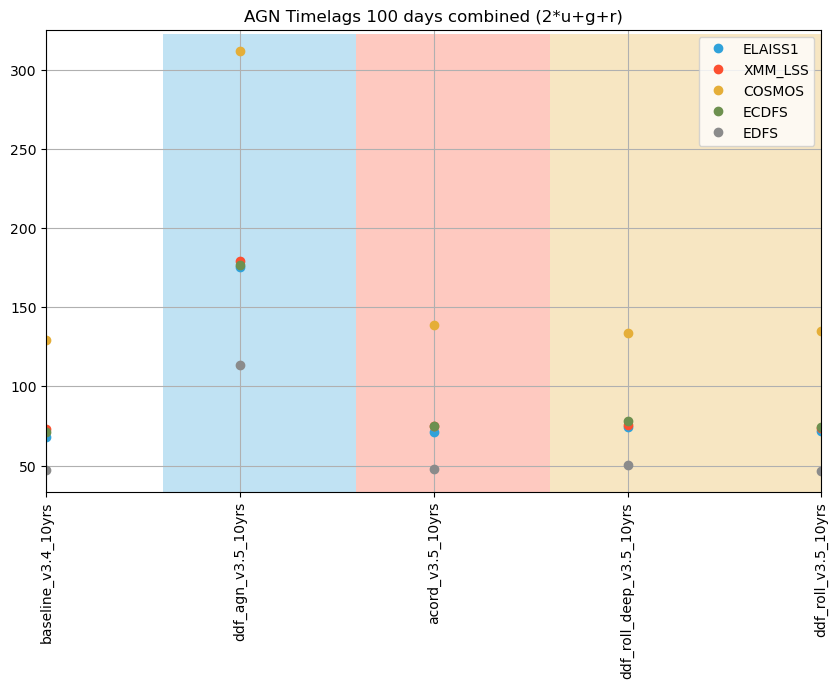

In [19]:
msub = metric_subsets.loc['AGN TimeLag 100 days DDF'].query('not metric.str.contains("WFD") and not metric.str.contains("all bands")')
u = msub.iloc[::6]
g = msub.iloc[1::6]
r = msub.iloc[2::6]
ddf_names = [i.split("DD:")[1].split(' ')[0] for i in r['metric']]
values = pd.DataFrame(summaries.loc[all_runs, u['metric']].values * 2 
                      + summaries.loc[all_runs, g['metric']].values * 1 
                      + summaries.loc[all_runs, r['metric']].values * 1,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(values, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii
# ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN Timelags 100 days combined (2*u+g+r)")

Text(0.5, 1.0, 'AGN Timelags 5 days all bands')

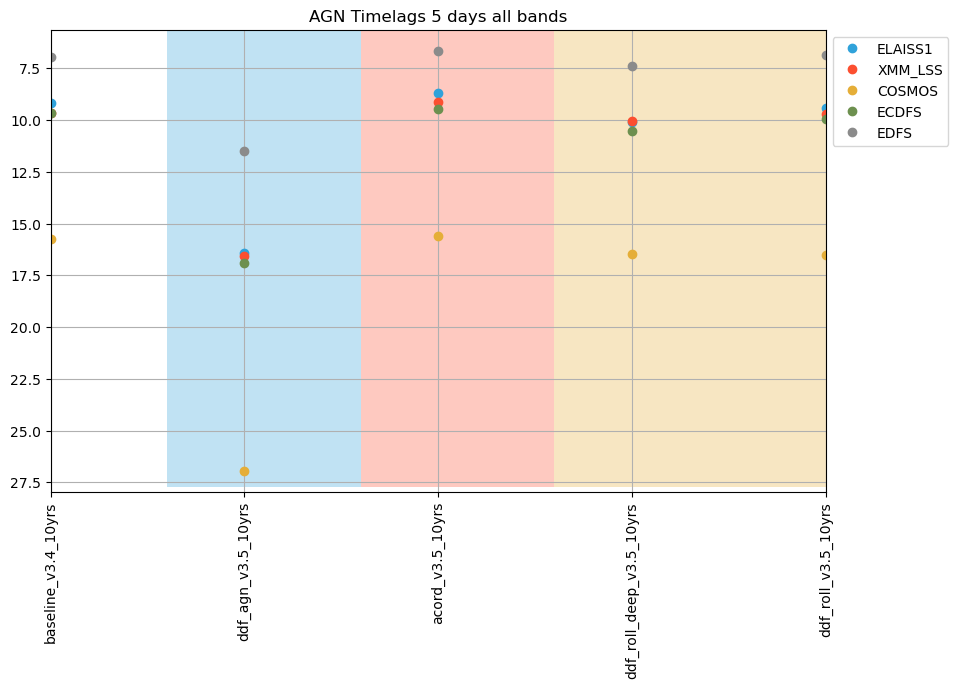

In [20]:
msub = metric_subsets.loc['AGN TimeLag 5 days DDF'].query('not metric.str.contains("WFD") and metric.str.contains("all bands")')

ddf_names = [i.split("DD:")[1].split(' ')[0] for i in msub['metric']]
values = pd.DataFrame(summaries.loc[all_runs, msub['metric']].values,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(values, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii
ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN Timelags 5 days all bands")

#### AGN summary:

The surprising thing here is that the `ddf_agn` run, which inadvertently increased the total number of DDF visits by a factor of 2, and in bands that are preferable for AGN -- did not improve AGN metrics by a similar amount. 

The AGN Structure Function Error metric and the AGN 100-day and 5-day Time Lags (both plotted here so that "up" is "better") show conflicting results -- the ddf_agn run was better for measuring 100 day lags, but worse at 5 day lags. The other runs were similar to the baseline.

### SNIa metrics 

The SNIa metrics run here with an nside of 128, which is significantly higher resolution than we use for evaluating the main survey. 

These need to be rerun for v3.5 -- the metric uses a value from the scheduler which has been replaced, but the metric isn't updated yet. 

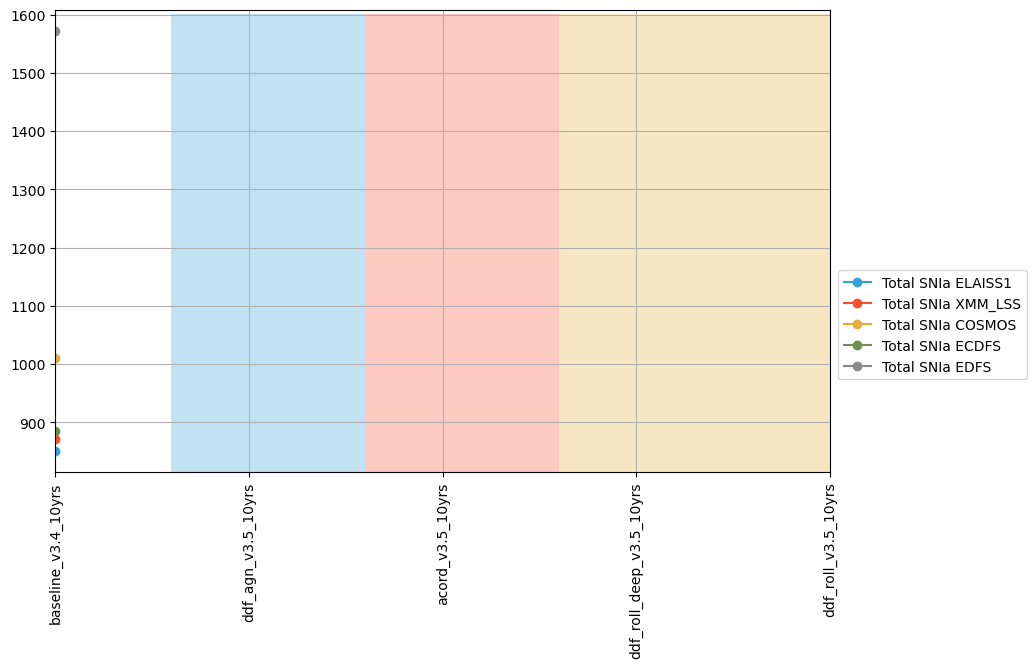

In [21]:
msub = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("Sum")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

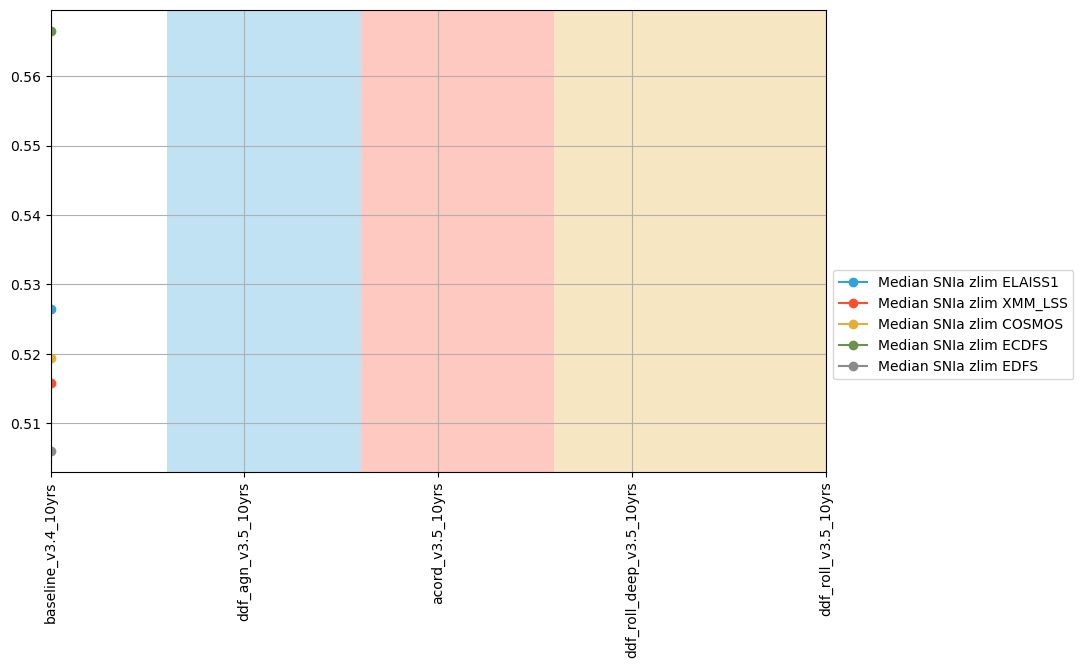

In [22]:
msub = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("zlim")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

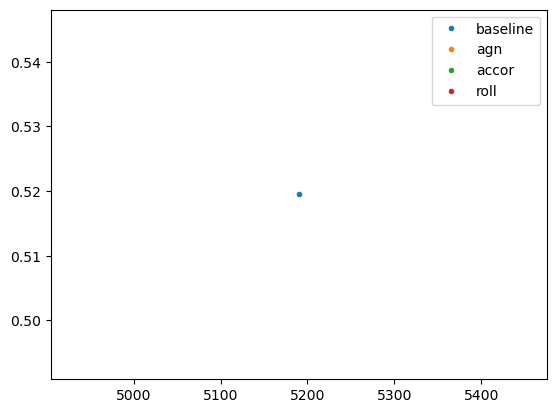

In [23]:
msub1 = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("Sum")')
msub2 = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("zlim")')
total_sn = summaries.loc[all_runs, msub1['metric']].sum(axis=1)
median_zlim = summaries.loc[all_runs, msub2['metric']].median(axis=1)

for fam, label in zip([[baselinerun], ddf_agn, ddf_accor, ddf_roll], ['baseline', 'agn', 'accor', 'roll']):
    plt.plot(total_sn.loc[fam], median_zlim.loc[fam], marker='.', linestyle='', label=label)
plt.legend()

#### SNIa summary

No results yet.


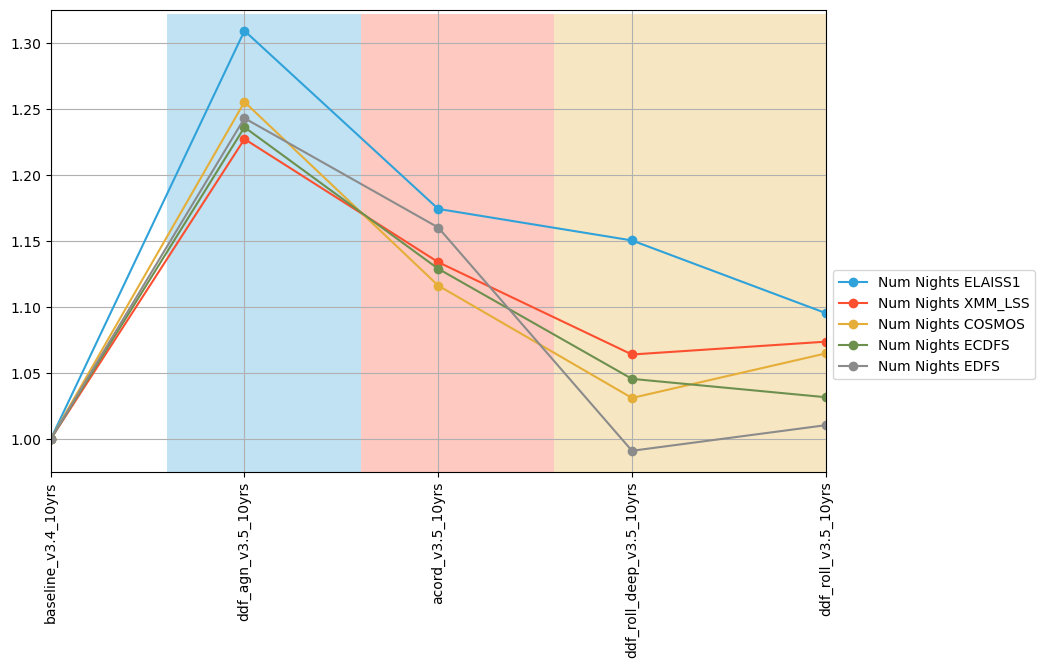

In [24]:
msub = metric_subsets.loc['DDF Cadence'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("N Unique")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

## SLSN

Strongly lensed SN

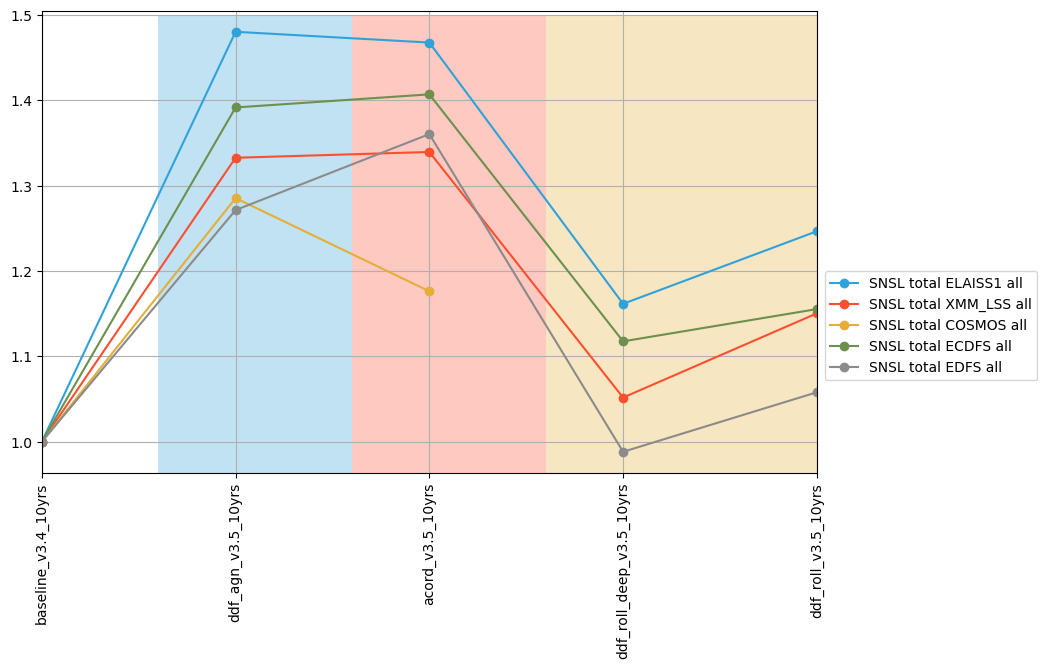

In [25]:
msub = metric_subsets.loc['SNSL DDF'].query('not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

One of the big drivers for discovering strongly lensed supernova is having lots of opportunities to discover these rare events. Having more unique nights with observations works in favor of this metric. The 'roll' family doesn't dramatically increase this number of unique nights. 

## KNe metrics

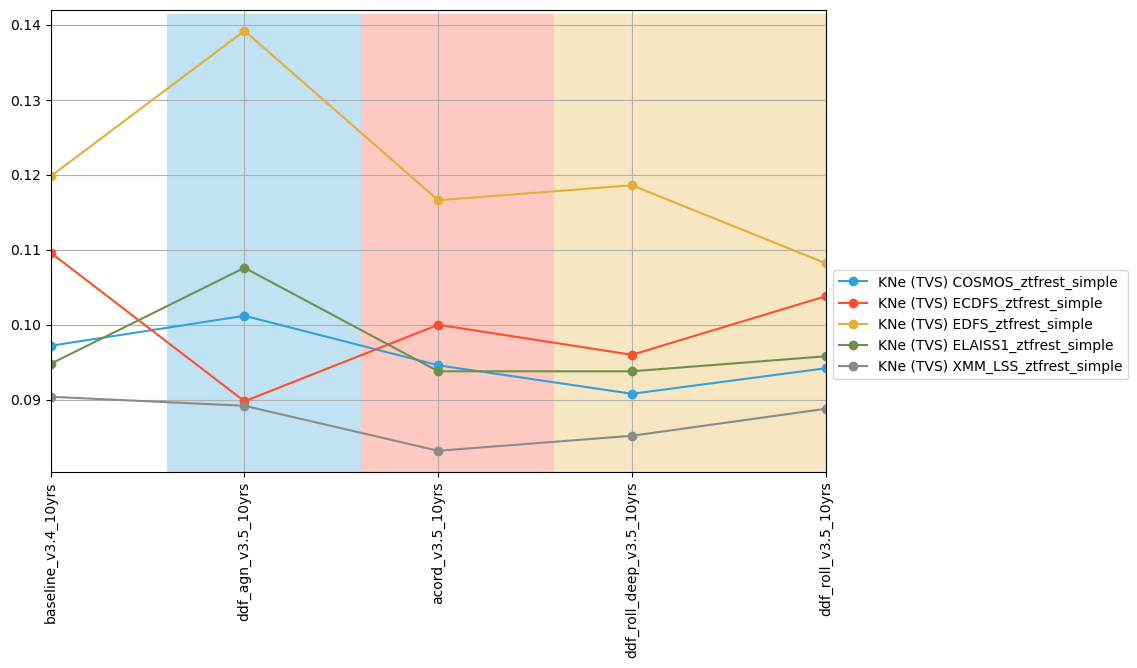

In [26]:
metrics = [m for m in summaries if 'KNe' in m and 'ztfrest_simple ' in m 
           and 'DD' in m and "Fraction detected in footprint" in m and 'WFD' not in m]
short_names = [f"KNe (TVS) {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

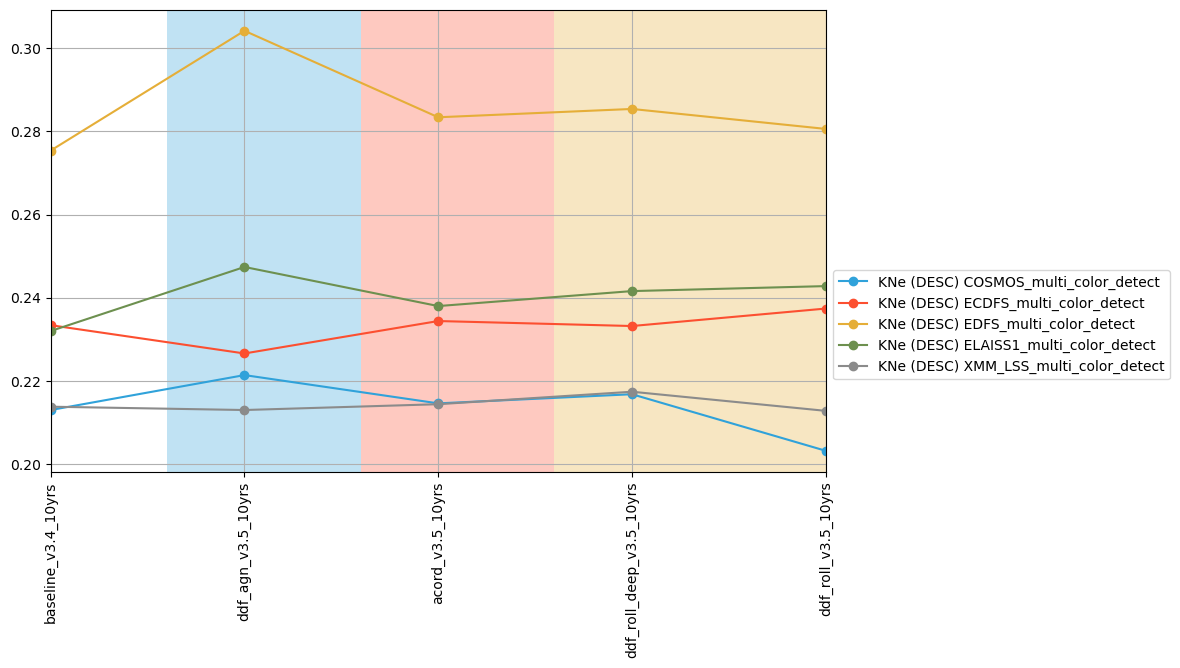

In [27]:
metrics = [m for m in summaries if 'KNe' in m  and 'multi_color_detect' in m 
           and 'DD' in m and "Fraction detected in footprint" in m and 'WFD' not in m]
short_names = [f"KNe (DESC) {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

### Weak Lensing nvisits

The weak lensing metric counts exposure time in gri or riz bands.

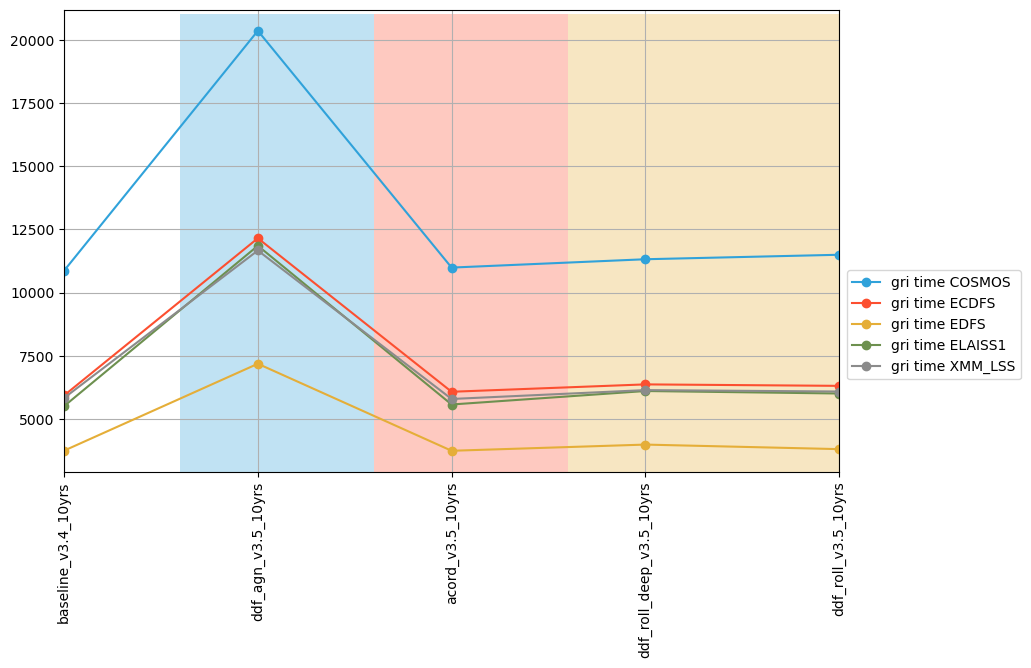

In [28]:
metrics = [m for m in summaries if "Weak" in m and "DD:" in m and "Median" in m and 'WFD' not in m and 'gri' in m]
short_names = [f"gri time {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

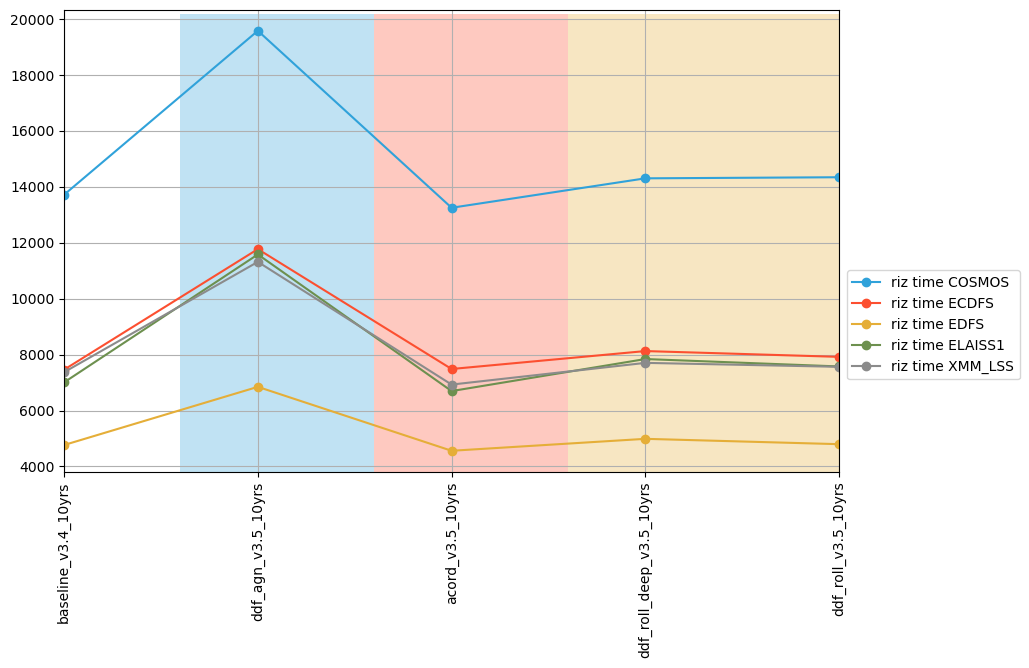

In [29]:
metrics = [m for m in summaries if "Weak" in m and "DD:" in m and "Median" in m and 'WFD' not in m and 'riz' in m]
short_names = [f"riz time {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii